# **sales_predictions**

Olen Sluder

*A portfolio project demonstrating sales predictions for items sold at various retail outlets. The goal is to help the retailer understand the properties of items and outlets that play roles in increasing sales.*

## Data Dictionary

| Column Name | Type | Description |
|-|-|-|
| Item_Identifier | String | Unique product ID |
| Item_Weight | Float | Weight of product |
| Item_Fat_Content | String | Whether the product is low fat or regular |
| Item_Visibility | Float | The percentage of total display area of all products in a store allocated to the particular product |
| Item_Type | String | The category to which the product belongs |
| Item_MRP | Float | Maximum Retail Price (list price) of the product
| Outlet_Identifier | String | Unique store ID |
| Outlet_Establishment_Year | Integer | The year in which store was established |
| Outlet_Size | String | The size of the store in terms of ground area covered |
| Outlet_Location_Type | String | The type of area in which the store is located |
| Outlet_Type | String | Whether the outlet is a grocery store or some sort of supermarket |
| Item_Outlet_Sales | Float | Sales of the product in the particular store |

## Helper Code

> Programs must be written for people to read, and only incidentally for machines to execute. ―Harold Abelson and Gerald Jay Sussman, *Structure and Interpretation of Computer Programs* (1984)

In [806]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn as skl
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor


# Check the current version of packages in Colab
print('Package Versions:')
print(f'\tMatplotlib = {mpl.__version__}')
print(f'\tNumPy = {np.__version__}')
print(f'\tPandas = {pd.__version__}')
print(f'\tScikit-learn = {skl.__version__}')
print(f'\tSciPy = {scipy.__version__}')
print(f'\tSeaborn = {sns.__version__}')


class ItemFatContentTransformer(BaseEstimator, TransformerMixin):
  """
  A custom transformer for item fat content.
  """
  def fit(self, X, y=None):
    return self


  def transform(self, X):
    """
    Perform transformation.

    Args:
      self (ItemVisibilityTransformer): This class instance.
      X (pandas.core.frame.DataFrame): Data frame to transform.

    Returns:
      pandas.core.frame.DataFrame: The transformed data frame.
    """
    X.replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

    return X


  def fit_transform(self, X, y=None):
    self.fit(X, y)

    return self.transform(X)


class ItemVisibilityTransformer(BaseEstimator, TransformerMixin):
  """
  A custom transformer for item visibility.
  """
  def fit(self, X, y=None):
    return self


  def transform(self, X):
    """
    Perform transformation.

    Args:
      self (ItemVisibilityTransformer): This class instance.
      X (pandas.core.frame.DataFrame): Data frame to transform.

    Returns:
      pandas.core.frame.DataFrame: The transformed data frame.
    """
    X.replace({0.0: np.nan})

    return X


  def fit_transform(self, X, y=None):
    self.fit(X, y)

    return self.transform(X)


def change_data_type(series, 
                     new_type):
  """
  Change a pandas Series' data type.

  Args:
    series (pandas.core.Series): The Series having its data type changed.
    new_type (type): The data type to change the Series to.
    
  Returns:
    pandas.core.Series: The new Series else the original column.
  """
  try:
    new_series = series.astype(new_type)
  except ValueError as ex:
    new_series = series
    display(ex)

  return new_series


def display_duplicate_count(data):
  """
  Display a pandas DataFrame's duplicate count.

  Args:
    data (pandas.core.DataFrame): The DataFrame being checked for duplicates.
  """
  try:
    count = data.duplicated().sum()
    print(f'There are {count} duplicates.')
  except AttributeError as ex:
    display(ex)

  return


def display_missing_data(data):
  """
  Display a pandas DataFrame's column(s) with missing data.

  Args:
    data (pandas.core.DataFrame): The DataFrame being checked for missing data.
  """
  try:
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    if len(missing_data) == 0:
      print('There is no missing data.')
    else:
      print(missing_data)
  except AttributeError as ex:
    display(ex)
 
  return


def barplot(data,
            x,
            figsize=(10, 5),
            tight_layout=True,
            title='',
            xlabel='',
            xtick_labels=[],
            xtick_rotation=0):
  """
  Plot bar plot for specified column.

  Args:
    data (pandas.core.DataFrame): The DataFrame being plotted.
    x (str): The name of the column to plot on the x-axis.
    figsize (tuple): The size of the plot's figure.
    tight_layout (bool): Create a tight plot layout?
    title (str): The title of the plot.
    xlabel (str): The x-axis label.
    xtick_labels (list): The x-tick labels.
    xtick_rotation (int): The degrees to rotate the x-tick labels.

  Returns:
    matplotlib.axes._subplots.AxesSubplot: The subplot.
  """
  plt.figure(figsize=figsize)

  ax = sns.countplot(data=data, x=x)

  ax.set_title(title)

  if len(xlabel) > 0:
    ax.set_xlabel(xlabel)

  plt.xticks(rotation=xtick_rotation)

  if len(xtick_labels) > 0:
    ax.set_xticklabels(xtick_labels)

  if tight_layout:
    plt.tight_layout()

  return ax


def whaleyplot(data,
               x,
               figsize=(10, 5),
               meanprops={'color': 'red', 'linestyle': '--'},
               medianprops={'color': 'black', 'linestyle': '--'},
               notch=False,
               tight_layout=True,
               title='',
               xlabel=''):
  """
  Plot histogram and boxplot on same x-axis for specified column.
 
  Args:
    data (pandas.core.DataFrame): The DataFrame being plotted.
    x (str): The name of the column to plot on the x-axis.
    figsize (tuple): The size of the plot's figure.
    meanprops (Dict): Properties of the mean line.
    medianprops (Dict): Properties of the median line.
    notch (bool): Should the box be notched?
    tight_layout (bool): Create a tight plot layout?
    title (str): The title of the plot.
    xlabel (str): The x-axis label.

  Returns:
    matplotlib.figure.Figure: The subplot figure.
    numpy.ndarray: The subplot axes.

 TODO:
    Implement meanprops and medianprops.
  """
  # Derived from S. Whaley/Coding Dojo, Exemplar DS Project 1
  fig, (histplot, boxplot) = plt.subplots(nrows=2, figsize=figsize, sharex=True)

  sns.histplot(ax=histplot, data=data, x=x, kde=True, legend=True)
  sns.boxplot(ax=boxplot, data=data, x=x, notch=notch)

  mean_value = data[x].mean()
  histplot.axvline(mean_value,
                   color='red', 
                   linestyle='-', 
                   label=f'Mean = {mean_value:,.2f}')
  boxplot.axvline(mean_value,
                  color='red', 
                  linestyle='-')
  
  median_value = data[x].median()
  histplot.axvline(median_value,
                   color='black', 
                   linestyle='-', 
                   label=f'Median = {median_value:,.2f}')
  boxplot.axvline(median_value,
                  color='black', 
                  linestyle='-')
  
  histplot.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
  histplot.set_title(title)

  if len(xlabel) > 0:
    boxplot.set_xlabel(xlabel)
  else:
    boxplot.set_xlabel(x)

  if tight_layout:
    plt.tight_layout()

  return fig, (histplot, boxplot)


# Luke Codewalker returns!!

Package Versions:
	Matplotlib = 3.5.3
	NumPy = 1.22.4
	Pandas = 1.3.5
	Scikit-learn = 1.2.1
	SciPy = 1.10.1
	Seaborn = 0.11.2


## Load Data

In [807]:
dataset = 'sales_predictions.csv'
df = pd.read_csv(dataset)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Clean Data

### Dataset Shape

In [808]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Duplicates

In [809]:
display_duplicate_count(df)

There are 0 duplicates.


### Missing Data

In [810]:
display_missing_data(df)

Item_Weight    1463
Outlet_Size    2410
dtype: int64


We will fill missing weights from other rows of the same item identifier.

In [811]:
# Create filter of items missing weights and create lookup dataframe of item weights
items_missing_weights = df[df['Item_Weight'].isna()]['Item_Identifier']
filter = df['Item_Identifier'].isin(items_missing_weights)
missing_item_weights = df[filter][['Item_Identifier', 'Item_Weight']]
missing_item_weights = missing_item_weights.dropna()
missing_item_weights = missing_item_weights.drop_duplicates()

# Fill missing weights from lookup dataframe
for item in missing_item_weights['Item_Identifier']:
  filter = missing_item_weights['Item_Identifier'] == item
  weight = missing_item_weights[filter]['Item_Weight'].iloc[0]
  filter = df['Item_Identifier'] == item
  df[filter] = df[filter].fillna({'Item_Weight': weight})

# Check for missing data
display_missing_data(df)

Item_Weight       4
Outlet_Size    2410
dtype: int64


We will fill remaining missing item weights with the mean of that item type's weight:

In [812]:
# Create dataframe of item types missing weights
item_types_missing_weights = df[df['Item_Weight'].isna()]['Item_Type']
item_types_missing_weights = item_types_missing_weights.dropna()
item_types_missing_weights = item_types_missing_weights.drop_duplicates()

# Fill remaining missing weights with mean of that item type's weight
for item_type in item_types_missing_weights:
  filter = df['Item_Type'] == item_type
  weight = df[filter]['Item_Weight'].mean()
  df[filter] = df[filter].fillna({'Item_Weight': weight})

# Check for missing data
display_missing_data(df)

Outlet_Size    2410
dtype: int64


Explore the outlet data to see if there appears to be any relationships to fill missing outlet size data.

In [813]:
df[['Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']].value_counts(dropna=False)

Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type      
OUT027             1985                       Medium       Tier 3                Supermarket Type3    935
OUT013             1987                       High         Tier 3                Supermarket Type1    932
OUT035             2004                       Small        Tier 2                Supermarket Type1    930
OUT046             1997                       Small        Tier 1                Supermarket Type1    930
OUT049             1999                       Medium       Tier 1                Supermarket Type1    930
OUT045             2002                       NaN          Tier 2                Supermarket Type1    929
OUT018             2009                       Medium       Tier 3                Supermarket Type2    928
OUT017             2007                       NaN          Tier 2                Supermarket Type1    926
OUT010             1998                       NaN    

- Grocery stores are likely all small, so fill missing values with 'Small'.
- There does not appear to be any relationships for supermarkets that can be used to fill missing values, so fill them with 'Unknown'.

In [814]:
filter = df['Outlet_Type'] == 'Grocery Store'
df[filter] = df[filter].fillna({'Outlet_Size': 'Small'})
df = df.fillna({'Outlet_Size': 'Unknown'})

Confirm there is no longer any missing data.

In [815]:
display_missing_data(df)

There is no missing data.


### Bad Data and Data Types

Check the data types.

In [816]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Explore the columns' values.

In [817]:
# Item_Identifier
df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

- These values look reasonable.

In [818]:
# Item_Weight
df['Item_Weight'].describe()

count    8523.000000
mean       12.875418
std         4.645016
min         4.555000
25%         8.785000
50%        12.650000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

- These values look reasonable.

In [819]:
# Item_Fat_Content
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

- This categorical data needs to be standardized. Based on the higher counts for these values, the correct values should be 'Low Fat' and 'Regular'.

In [820]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 
                                                         'low fat': 'Low Fat', 
                                                         'reg': 'Regular'})

# Verify the data is correct
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- These values look reasonable.

In [821]:
# Item_Visibility
df['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

- These values look reasonable.

In [822]:
# Item_Type
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

- These values look reasonable.

In [823]:
# Item_MRP
df['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

- These values look reasonable.

In [824]:
# Outlet_Identifier
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

- These values look reasonable.

In [825]:
# Outlet_Establishment_Year
df['Outlet_Establishment_Year'].describe()

count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64

- These values look reasonable.

In [826]:
# Outlet_Size
df['Outlet_Size'].value_counts()

Small      2943
Medium     2793
Unknown    1855
High        932
Name: Outlet_Size, dtype: int64

- These values look reasonable.

In [827]:
# Outlet_Location_Type
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

- These values look reasonable.

In [828]:
# Outlet_Type
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

- These values look reasonable.

In [829]:
# Item_Outlet_Sales
df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

- These values look reasonable.

## Exploratory Data Analyses

### Univariate Analyses

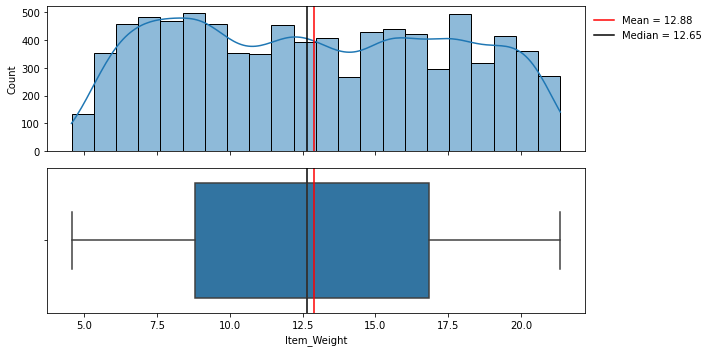

In [830]:
# Item_Weight
whaleyplot(df, 'Item_Weight')
plt.show()

- Item weights are fairly evenly distributed around the mean of 12.88.
- There are multiple peaks indicating underlying data clusters.

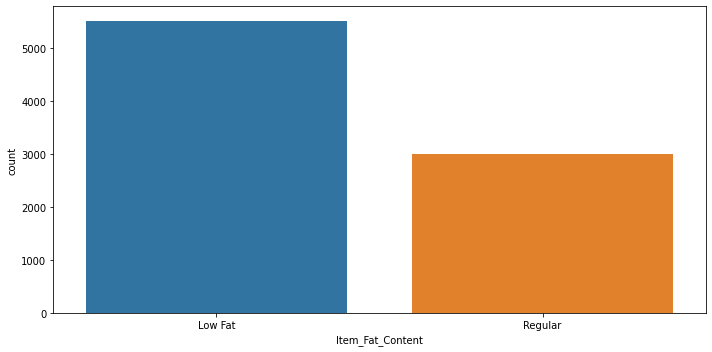

In [831]:
# Item_Fat_Content
barplot(df, 'Item_Fat_Content')
plt.show()

* Most of the data is from 'Low Fat' items.

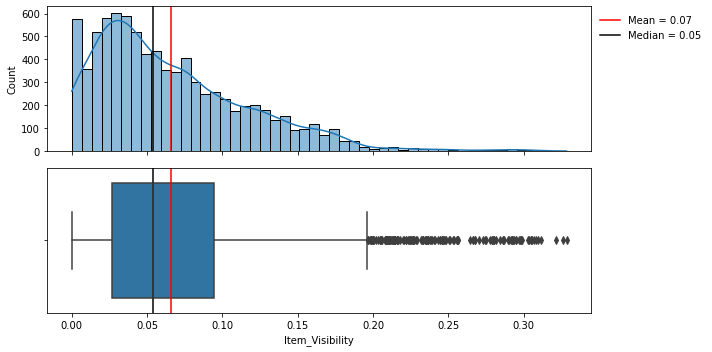

In [832]:
# Item_Visibility
whaleyplot(df, 'Item_Visibility')
plt.show()

- There are multiple peaks indicating underlying data clusters.
- The "real" peak of the distribution occurs around the first quartile.

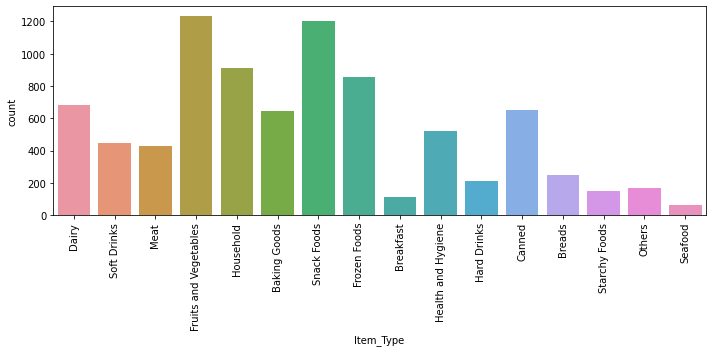

In [833]:
# Item_Type
barplot(df, 'Item_Type', xtick_rotation=90)
plt.show()

- The top three item types are 'Fruits and Vegetables', 'Snack Foods', and 'Household'.

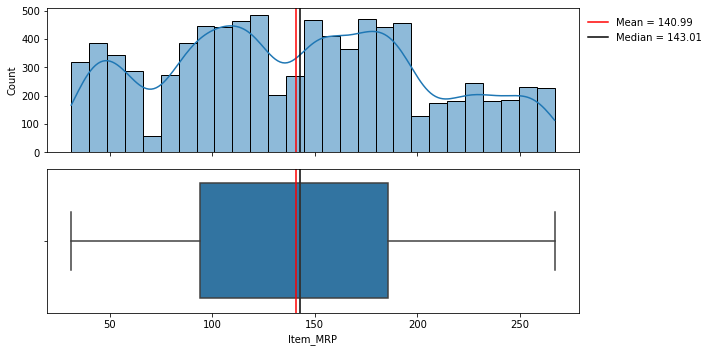

In [834]:
# Item_MRP
whaleyplot(df, 'Item_MRP')
plt.show()

- The items' prices are fairly evenly distributed around the mean of 140.99.
- There are multiple peaks indicating underlying data clusters.

Small      2943
Medium     2793
Unknown    1855
High        932
Name: Outlet_Size, dtype: int64 



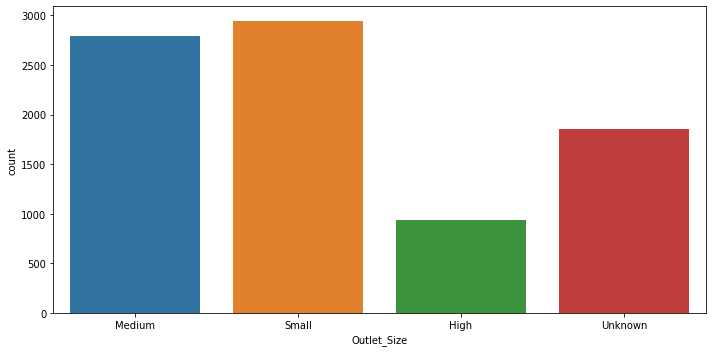

In [835]:
# Outlet_Size
print(df['Outlet_Size'].value_counts(), '\n')
barplot(df, 'Outlet_Size')
plt.show()

- The counts of data for 'Medium' (2,793) and 'Small' (2,943) outlet sizes are roughly the same. 'High' together with 'Unknown' make up a similar count (2,787).

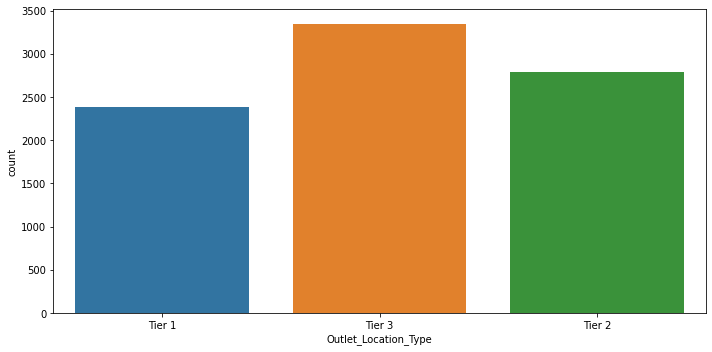

In [836]:
# Outlet_Location_Type
barplot(df, 'Outlet_Location_Type')
plt.show()

- A large part of the data comes from 'Tier 3' outlets.

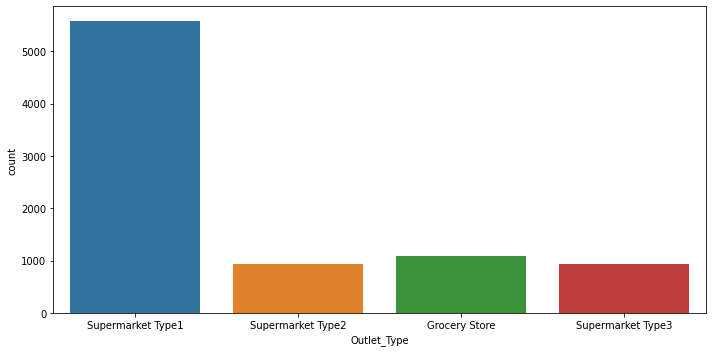

In [837]:
# Outlet_Type
barplot(df, 'Outlet_Type')
plt.show()

- Most of the data comes from 'Supermarket Type1' outlets.

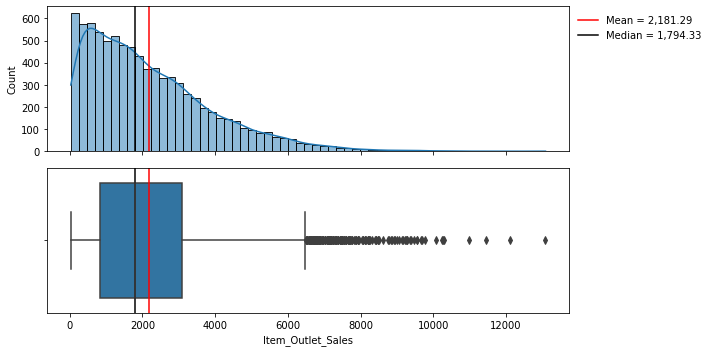

In [838]:
# Item_Outlet_Sales
whaleyplot(df, 'Item_Outlet_Sales')
plt.show()

- Most of the item outlet sales are less than 2,000.

### Multivariate Analyses

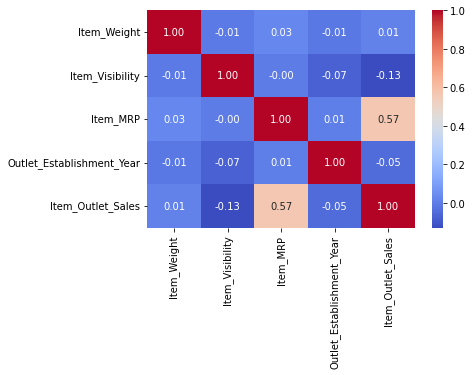

In [839]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

- There is a moderate positive correlation between item price and item outlet sales.
- There are no other notable positive correlations.
- There are no notable negative correlations.

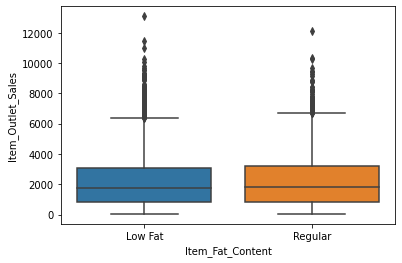

In [840]:
# Item_Fat_Content v. Item_Outlet_Sales
sns.boxplot(data=df, x='Item_Fat_Content', y='Item_Outlet_Sales')
plt.show()

- 'Low Fat' and 'Regular' sales are about the same.

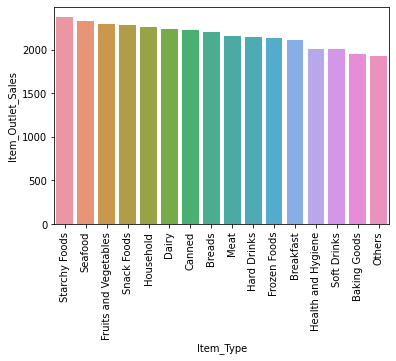

In [841]:
# Item_Type v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)

ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)

plt.xticks(rotation=90)
ax.set_ylabel('Item_Outlet_Sales')

plt.show()

- The top three item types by mean sales are 'Starchy Foods', 'Seafood', and 'Fruits and Vegetables'.

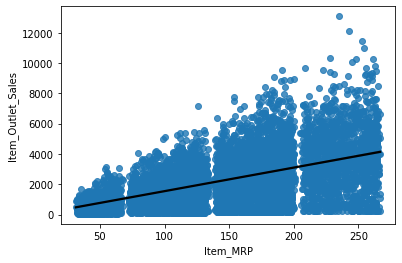

In [842]:
# Item_MRP v. Item_Outlet_Sales
ax = sns.regplot(data=df, 
                 x='Item_MRP', y='Item_Outlet_Sales', 
                 line_kws={'color': 'black', 'linestyle': '-'})

plt.show()

- There is a moderate positive correlation between item price and sales.

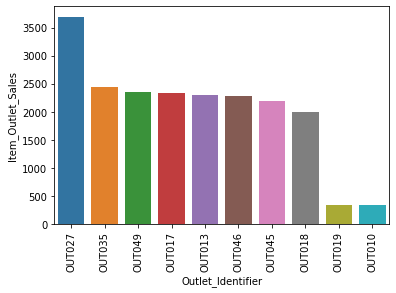

In [843]:
# Outlet_Identifier v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().sort_values(ascending=False)

ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)

plt.xticks(rotation=90)
ax.set_ylabel('Item_Outlet_Sales')

plt.show()

- OUT027 has the highest mean sales.

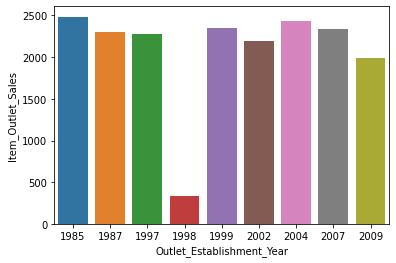


Outlets established in 1998: OUT010


In [844]:
# Outlet_Establishment_Year v. Item_Outlet_Sales
sales_by_establishment_year = df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean()

ax = sns.barplot(x=sales_by_establishment_year.index, 
                 y=sales_by_establishment_year.values)

ax.set_ylabel('Item_Outlet_Sales')

plt.show()

# Which outlets were established in 1998?
filter = df['Outlet_Establishment_Year'] == 1998
outlets = df[filter]['Outlet_Identifier'].value_counts().index[0]
print(f'\nOutlets established in 1998: {outlets}')

- The outlet established in 1998, OUT010, has the lowest mean item outlet sales by over a factor of 5.

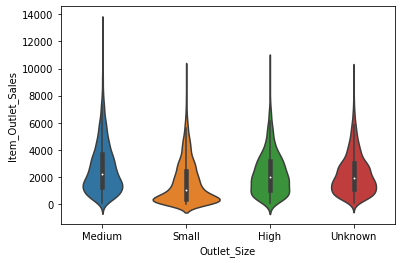

In [845]:
# Outlet_Size v. Item_Outlet_Sales
sns.violinplot(data=df, 
               x='Outlet_Size', y='Item_Outlet_Sales')

plt.show()

- 'Medium' outlets have the highest sales.
- 'Small' outlets have a larger number of lower sales.

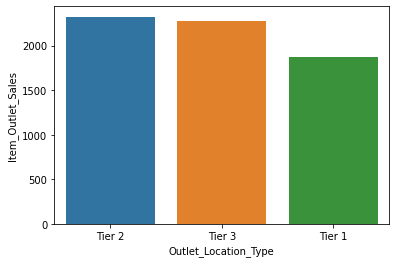

In [846]:
# Outlet_Location_Type v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)

ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)

ax.set_ylabel('Item_Outlet_Sales')

plt.show()

- 'Tier 1' outlets have the lowest mean item outlet sales.

Outlet_Type
Supermarket Type3    3694.038558
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Grocery Store         339.828500
Name: Item_Outlet_Sales, dtype: float64 



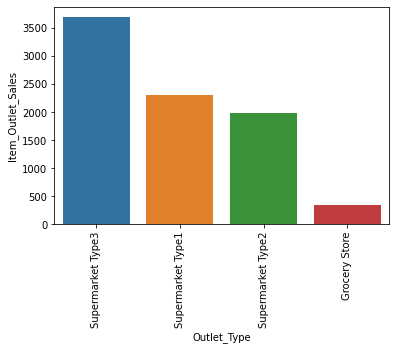

In [847]:
# Outlet_Type v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
print(sales_by_outlet, '\n')

ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)

plt.xticks(rotation=90)
ax.set_ylabel('Item_Outlet_Sales')

plt.show()

- 'Supermarket Type3' outlets have the highest mean item outlet sales.
- 'Grocery Store' outlets have the lowest mean item outlet sales by over one order of magnitude.

## Explanatory Data Analyses

### Does the item price and the outlet type impact sales?

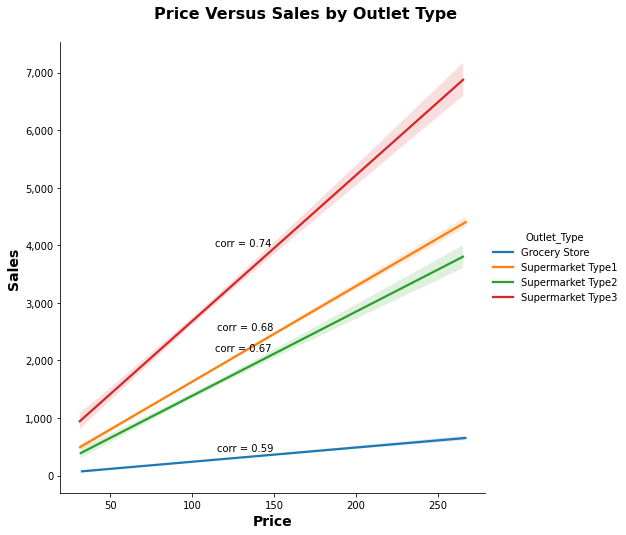

In [848]:
fg = sns.lmplot(data=df, 
                x='Item_MRP', y='Item_Outlet_Sales', 
                fit_reg=True, 
                height=7,
                hue='Outlet_Type', 
                hue_order=sorted(df['Outlet_Type'].unique()),
                scatter=False) # Don't show the scatterplot

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

fg.set_axis_labels('Price', 'Sales', font={'size': 14, 'weight': 'bold'})

# Add correlation coefficients to the regression lines generated by hue
for ax in fg.axes.flat:
  for line in ax.lines:
    # Calculate Pearson correlation coefficient for outlet type
    filter = df['Outlet_Type'] == line.get_label()
    x = df[filter]['Item_MRP']
    y = df[filter]['Item_Outlet_Sales']
    corr_coef, _ = pearsonr(x, y)

    # Place coefficient near mean of xdata and ydata values
    xdata, ydata = line.get_xdata(), line.get_ydata()
    ax.annotate('corr = {:.2f}'.format(corr_coef),
                xy=(xdata.mean(), ydata.mean()),
                xytext=(0, 2),
                textcoords='offset points',
                ha='right', va='bottom')

fg.fig.suptitle('Price Versus Sales by Outlet Type', 
                fontsize=16, fontweight='bold', y=1.05)

plt.show()

- Different outlets types have different correlations between item price and item outlet sales with 'Supermarket Type3' outlets having a higher positive correlation than the others in particular grocery stores.
- Sales can be increased by increasing item prices at all outlet types, but 'Supermarket Type3' outlets can probably bear higher increases.

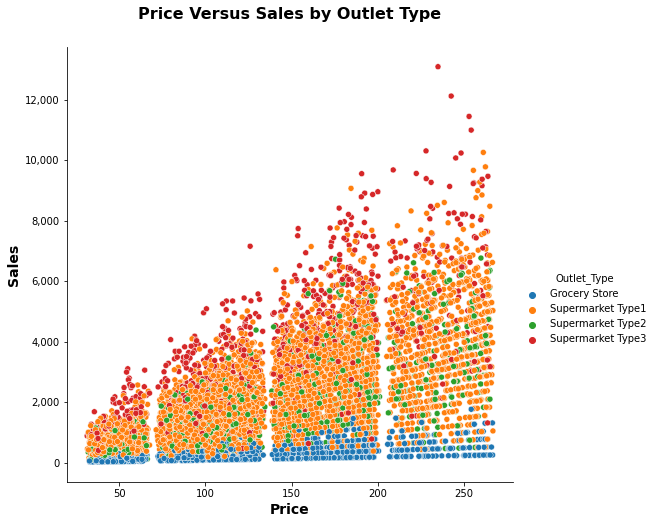

In [849]:
plt.figure(figsize=(8, 8))

ax = sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', 
                     data=df, 
                     hue='Outlet_Type',
                     hue_order=sorted(df['Outlet_Type'].unique()))

plt.legend(title='Outlet_Type', bbox_to_anchor=(1, 0.5), frameon=False)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('Price', fontsize=14, fontweight='bold')
ax.set_ylabel('Sales', fontsize=14, fontweight='bold')

ax.set_title('Price Versus Sales by Outlet Type', 
             fontsize=16, fontweight='bold', y=1.05)

sns.despine() # Get rid of upper and right spines
plt.show()

- In addition to varying between outlet types, the correlation between item price and item outlet sales is not linear: there are items with high prices that do not sell well and items with low prices that sell well.

- The retailer may want to adjust the prices of certain items to increase their sales or promote higher-priced items with a strong sales record. They could also investigate why certain items with high prices are not selling well.

### Do different types of outlets carry different types of items?

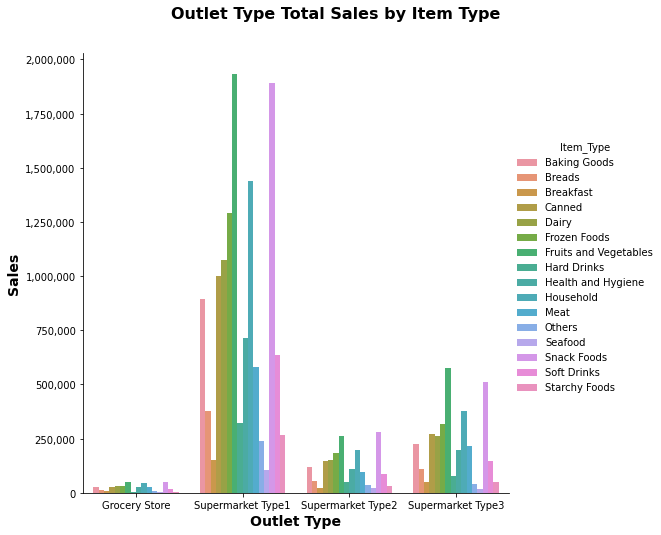

,Outlet_Type,Item_Type,Item_Outlet_Sales
13,Grocery Store,Snack Foods,51596.1710
6,Grocery Store,Fruits and Vegetables,48602.0684
9,Grocery Store,Household,43707.1068


In [850]:
sales_by_outlet_type_item_type = df.groupby(['Outlet_Type', 'Item_Type'])['Item_Outlet_Sales'].sum().reset_index()

fg = sns.catplot(x='Outlet_Type', y='Item_Outlet_Sales', 
                 data=sales_by_outlet_type_item_type, 
                 height=7, 
                 hue='Item_Type', 
                 kind='bar')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

fg.set_axis_labels('Outlet Type', 'Sales', font={'size': 14, 'weight': 'bold'})

fg.fig.suptitle('Outlet Type Total Sales by Item Type', 
                fontsize=16, fontweight='bold', y=1.05)

plt.show()

filter = sales_by_outlet_type_item_type['Outlet_Type'] == 'Grocery Store'
grocery_store_item_types = sales_by_outlet_type_item_type[filter]
grocery_store_item_types.sort_values(by='Item_Outlet_Sales', ascending=False).head(3)

- The types of items sold varies across outlet types. In 'Supermarket Type1' outlets, the top-selling item types are 'Fruits and Vegetables', 'Snack Foods', and 'Household'. Other supermarket outlet types follow a similar pattern, but with lower total sales. In 'Grocery Store' outlets, the top-selling item types are 'Snack Foods', 'Fruits and Vegetables', and 'Household'.

- The retailer may want to promote the top-selling items in each outlet type to increase sales.

## Preprocessing for Machine Learning

### Reload Data

In [851]:
df = pd.read_csv(dataset)

Drop the item identifier column to reduce the sparsity and improve metrics.

In [852]:
df = df.drop(columns=['Item_Identifier'])

### Explore Data

In [853]:
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB



,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Feature (X) classification for transformations.

| Column | Type |
|-|-|
| Item_Identifier | Categorical |
| Item_Weight | Numerical |
| Item_Fat_Content | Categorical |
| Item_Visibility | Numerical |
| Item_Type | Categorical |
| Item_MRP | Numerical |
| Outlet_Identifier | Categorical |
| Outlet_Establishment_Year | Numerical |
| Outlet_Size | Ordinal |
| Outlet_Location_Type | Ordinal |
| Outlet_Type | Categorical |

Target (y) is 'Item_Outlet_Sales'.

#### Duplicates

Check for duplicates.

In [854]:
display_duplicate_count(df)

There are 0 duplicates.


#### Missing Data

Check for missing data.

In [855]:
display_missing_data(df)

Item_Weight    1463
Outlet_Size    2410
dtype: int64


- Missing item weights will be imputed with `SimpleImputer(strategy='mean')`.
- Missing item visibilities will be imputed with `SimpleImputer(strategy='mean')`.
- Missing supermarket outlet sizes will be imputed with `SimpleImputer(strategy='most_frequent')`.

Based on univariate analysis, grocery stores are small, so change missing grocery store outlet sizes to 'Small'.

In [856]:
# Outlet_Size
filter = df['Outlet_Type'] == 'Grocery Store'
df[filter] = df[filter].fillna({'Outlet_Size': 'Small'})

In [857]:
display_missing_data(df)

Item_Weight    1463
Outlet_Size    1855
dtype: int64


### Validation Split

In [858]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Instantiate Column Selectors

In [859]:
# Generic selector(s)
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Column-specific selector(s)
item_fat_content_selector = ['Item_Fat_Content']
item_visibility_selector = ['Item_Visibility']
outlet_size_selector = ['Outlet_Size']
outlet_location_type_selector = ['Outlet_Location_Type']

### Instantiate Transformers

In [860]:
# Simple imputer(s)
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

# Custom transformer(s)
item_fat_content_transformer = ItemFatContentTransformer()
item_visibility_transformer = ItemVisibilityTransformer()

# Ordinal encoder(s)
outlet_location_type_encoder = OrdinalEncoder(categories=[['Tier 1', 
                                                           'Tier 2', 
                                                           'Tier 3']])
outlet_size_encoder = OrdinalEncoder(categories=[['Small',
                                                  'Medium', 
                                                  'High']])

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

### Instantiate Pipelines

In [861]:
# Categorical pipeline
cat_pipeline = make_pipeline(freq_imputer, ohe)
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [862]:
# Numerical pipeline
num_pipeline = make_pipeline(mean_imputer, scaler)
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [863]:
# Item_Fat_Content pipeline
item_fat_content_pipeline = make_pipeline(item_fat_content_transformer, 
                                          cat_pipeline)
item_fat_content_pipeline

Pipeline(steps=[('itemfatcontenttransformer', ItemFatContentTransformer()),
                ('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False))]))])

In [864]:
# Item_Visibility pipeline
item_visibility_pipeline = make_pipeline(item_visibility_transformer, 
                                         num_pipeline)
item_visibility_pipeline

Pipeline(steps=[('itemvisibilitytransformer', ItemVisibilityTransformer()),
                ('pipeline',
                 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())]))])

In [865]:
# Outlet_Location_Type pipeline
outlet_location_type_pipeline = make_pipeline(freq_imputer, 
                                              outlet_location_type_encoder, 
                                              scaler)
outlet_location_type_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Tier 1', 'Tier 2', 'Tier 3']])),
                ('standardscaler', StandardScaler())])

In [866]:
# Outlet_Size pipeline
outlet_size_pipeline = make_pipeline(freq_imputer, 
                                     outlet_size_encoder, 
                                     scaler)
outlet_size_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                ('standardscaler', StandardScaler())])

### Instantiate Column Transformer

In [867]:
# Tuple(s) for column transformer
# Generic tuple(s)
cat_tuple = (cat_pipeline, cat_selector)
num_tuple = (num_pipeline, num_selector)

# Column-specific tuple(s)
item_fat_content_tuple = (item_fat_content_pipeline, item_fat_content_selector)
item_visibility_tuple = (item_visibility_pipeline, item_visibility_selector)
outlet_location_type_tuple = (outlet_location_type_pipeline, 
                              outlet_location_type_selector)
outlet_size_tuple = (outlet_size_pipeline, outlet_size_selector)

# Column transformer
preprocessor = make_column_transformer(item_fat_content_tuple,
                                       item_visibility_tuple,
                                       outlet_location_type_tuple,
                                       outlet_size_tuple,
                                       cat_tuple, 
                                       num_tuple, 
                                       remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('itemfatcontenttransformer',
                                                  ItemFatContentTransformer()),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]))]),
                                 ['Item_Fat_Content']),
                                ('pipeline-2',
                                 Pipeline(steps=[('itemvisi...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b31395b0>),
                                ('pipeline-6',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b0212b50>)])

### Transform Data

Fit on the training dataset.

In [868]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('itemfatcontenttransformer',
                                                  ItemFatContentTransformer()),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]))]),
                                 ['Item_Fat_Content']),
                                ('pipeline-2',
                                 Pipeline(steps=[('itemvisi...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b31395b0>),
                                ('pipeline-6',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b0212b50>)])

Transform the training and testing datasets.

In [869]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Inspect Results

In [870]:
# Check for missing values and that data is scaled and one-hot encoded
print(f'There are {np.isnan(X_train_processed).sum().sum()} missing values in the training data.')
print(f'There are {np.isnan(X_test_processed).sum().sum()} missing values in testing data', '\n')
print(f'All data types in the training data are {X_train_processed.dtype}.')
print(f'All data types in the testing data are {X_test_processed.dtype}.\n')
print(f'The training data has {X_train_processed.shape[0]:,} rows and {X_train_processed.shape[1]:,} columns.\n')
X_train_processed

There are 0 missing values in the training data.
There are 0 missing values in testing data 

All data types in the training data are float64.
All data types in the testing data are float64.

The training data has 6,392 rows and 53 columns.



array([[ 0.        ,  1.        ,  0.        , ..., -0.71277507,
         1.82810922,  1.32784893],
       [ 0.        ,  0.        ,  1.        , ..., -1.29105225,
         0.60336888,  1.32784893],
       [ 0.        ,  0.        ,  1.        , ...,  1.81331864,
         0.24454056,  0.13618724],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.92052713,
         1.52302674,  0.49368575],
       [ 0.        ,  0.        ,  0.        , ..., -0.2277552 ,
        -0.38377708,  1.0895166 ],
       [ 1.        ,  0.        ,  0.        , ..., -0.95867683,
        -0.73836105, -0.10214509]])

## Regression Models

### Linear Regression

In [871]:
lr = LinearRegression()
lr_pipe = make_pipeline(preprocessor, lr)

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('itemfatcontenttransformer',
                                                                   ItemFatContentTransformer()),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]))]),
                                                  ['Item_Fat_Content']),
                                                 ('p...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b31395b0>),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b0212b50>)])),
                ('linearregression', LinearRegression())])

In [872]:
y_hat_train = lr_pipe.predict(X_train)
y_hat_test = lr_pipe.predict(X_test)

In [873]:
train_r2 = r2_score(y_train, y_hat_train)
test_r2 = r2_score(y_test, y_hat_test)
print(f'R-Squared:\n\tTrain = {train_r2:.4f}\n\tTest = {test_r2:.4f}')

R-Squared:
	Train = 0.5608
	Test = 0.5663


In [874]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print(f'Root Mean Squared Error:\n\tTrain = {train_rmse:.4f}\n\tTest = {test_rmse:.2f}')

Root Mean Squared Error:
	Train = 1140.0225
	Test = 1093.86


### Decision Tree

Explore different depth decision trees.

In [875]:
depths = range(2, 51) # Try depths of 2 to 50
scores = pd.DataFrame(columns=['Train_R2', 'Test_R2'], index=depths)                      
for depth in depths:
  dtr = DecisionTreeRegressor(max_depth=depth, random_state=42)
  dtr_pipe = make_pipeline(preprocessor, dtr)
  dtr_pipe.fit(X_train, y_train)
  yhat_train = dtr_pipe.predict(X_train)
  yhat_test = dtr_pipe.predict(X_test)
  train_r2 = r2_score(y_train, yhat_train)
  test_r2 = r2_score(y_test, yhat_test)
  scores.loc[depth] = {'Train_R2': train_r2, 'Test_R2': test_r2}

scores.sort_values(by='Test_R2', ascending=False).head(1)

,Train_R2,Test_R2
5,0.603932,0.59472


In [876]:
dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
dtr_pipe = make_pipeline(preprocessor, dtr)

dtr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('itemfatcontenttransformer',
                                                                   ItemFatContentTransformer()),
                                                                  ('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]))]),
                                                  ['Item_Fat_Content']),
                                                 ('p...
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b31395b0>),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f77b0212b50>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [877]:
y_hat_train = dtr_pipe.predict(X_train)
y_hat_test = dtr_pipe.predict(X_test)

In [878]:
train_r2 = r2_score(y_train, y_hat_train)
test_r2 = r2_score(y_test, y_hat_test)
print(f'R-Squared:\n\tTrain = {train_r2:.4f}\n\tTest = {test_r2:.4f}')

R-Squared:
	Train = 0.6039
	Test = 0.5947


In [879]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print(f'Root Mean Squared Error:\n\tTrain = {train_rmse:.4f}\n\tTest = {test_rmse:.4f}')

Root Mean Squared Error:
	Train = 1082.6573
	Test = 1057.4299


### Model Selection

Based on r-squared and root mean squared error metrics which show a better fit, a decision tree model with max_depth=5 is the best choice for deployment versus a linear regression model.